# Budgeting stats for Onchain Builders

Here are metrics we'd like to understand from Retro Funding 4:

- OP spent per ETH in gas fees rewarded
- OP spent per ETH in Collective Contributions rewarded
- OP spent per Trusted user
- OP spent per active address

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Assums

PRE_4844_PROFIT = .5
POST_4844_PROFIT = .95
COLLECTIVE_CONTRIBUTION_RATE = .15

def contribution(chain, pre, post):
    ratio = 1.0 if chain == 'OPTIMISM' else COLLECTIVE_CONTRIBUTION_RATE
    return ratio * (pre * PRE_4844_PROFIT + post * POST_4844_PROFIT)

## Part 1. Grab relevant datasets from the round

In [3]:
df_projects = pd.read_csv('data/private/rf4_results.csv')
metric_cols = [
    'gas_fees', 'transaction_count', 'trusted_transaction_count', 'trusted_users_onboarded',
    'daily_active_addresses', 'trusted_daily_active_users', 'monthly_active_addresses',
    'trusted_monthly_active_users', 'recurring_addresses', 'trusted_recurring_users',
    'power_user_addresses', 'openrank_trusted_users_count'
]
df_projects = df_projects[metric_cols + ['rf4_allocation']]
rewards = df_projects['rf4_allocation']

total_rewards = round(rewards.sum())
print("Total rewards:", total_rewards, "OP")
print("Sample project:", df_projects.tail(1).T.to_dict())

Total rewards: 10000000 OP
Sample project: {229: {'gas_fees': 0.0068294836636379, 'transaction_count': 1266.0, 'trusted_transaction_count': 213.0, 'trusted_users_onboarded': 13.0, 'daily_active_addresses': 3.7336065573770494, 'trusted_daily_active_users': 0.7704918032786884, 'monthly_active_addresses': 92.71604938271604, 'trusted_monthly_active_users': 19.135802469135804, 'recurring_addresses': 19.0, 'trusted_recurring_users': 6.0, 'power_user_addresses': 159.0, 'openrank_trusted_users_count': 13.0, 'rf4_allocation': 0.0}}


In [4]:
summary_query = """
select
  count(distinct events.from_artifact_name) as num_address,
  count(distinct events.trusted_user_id) as unique_users
from `oso_production.rf4_events_daily_to_project` as events
join `oso_production.projects_v1` as projects_v1
  on events.project_id = projects_v1.project_id
join `static_data_sources.rf4_project_eligibility` as rf4_project_eligibility
  on projects_v1.project_name = rf4_project_eligibility.oso_name
where
  rf4_project_eligibility.is_approved is true
  and events.event_type = 'CONTRACT_INVOCATION_DAILY_L2_GAS_USED'
  and events.bucket_day >= '2023-10-01'
"""

summary_results = {
  "num_address": "3766317",
  "unique_users": "69704"
}

In [5]:
chain_query = """
select
  events.event_source,
  count(distinct events.from_artifact_name) as num_address,
  count(distinct events.trusted_user_id) as unique_users,
  sum(case when events.bucket_day < '2024-03-13' then events.amount / 1e18 end) as pre_4844_gas,
  sum(case when events.bucket_day >= '2024-03-13' then events.amount / 1e18 end) as post_4844_gas
from `oso_production.rf4_events_daily_to_project` as events
join `oso_production.projects_v1` as projects_v1
  on events.project_id = projects_v1.project_id
join `static_data_sources.rf4_project_eligibility` as rf4_project_eligibility
  on projects_v1.project_name = rf4_project_eligibility.oso_name
where
  rf4_project_eligibility.is_approved is true
  and events.event_type = 'CONTRACT_INVOCATION_DAILY_L2_GAS_USED'
  and events.bucket_day >= '2023-10-01'
group by 1
"""

chain_results = [{
  "event_source": "ZORA",
  "num_address": "734583",
  "unique_users": "38939",
  "pre_4844_gas": "186.7637756208259",
  "post_4844_gas": "4.7823080323663376"
}, {
  "event_source": "OPTIMISM",
  "num_address": "2083101",
  "unique_users": "51303",
  "pre_4844_gas": "526.74847179865549",
  "post_4844_gas": "236.79126479110465"
}, {
  "event_source": "MODE",
  "num_address": "188101",
  "unique_users": "25801",
  "pre_4844_gas": "166.80150148356421",
  "post_4844_gas": "17.208239850031493"
}, {
  "event_source": "BASE",
  "num_address": "2557075",
  "unique_users": "65238",
  "pre_4844_gas": "123.8961018449274",
  "post_4844_gas": "1152.5250485869817"
}, {
  "event_source": "FRAX",
  "num_address": "156",
  "unique_users": "14",
  "pre_4844_gas": "0.020074867323004304",
  "post_4844_gas": "0.012886408592121651"
}]

In [6]:
df_chains = pd.DataFrame(chain_results).set_index('event_source')
df_chains = df_chains.apply(pd.to_numeric)
df_chains['total_gas'] = df_chains['pre_4844_gas'] + df_chains['post_4844_gas']
df_chains['collective_contribution'] = df_chains.apply(
    lambda row: contribution(row.name, row['pre_4844_gas'], row['post_4844_gas']), axis=1
)
df_chains

,num_address,unique_users,pre_4844_gas,post_4844_gas,total_gas,collective_contribution
event_source,,,,,,
ZORA,734583,38939,186.763776,4.782308,191.546084,14.688762
OPTIMISM,2083101,51303,526.748472,236.791265,763.539737,488.325937
MODE,188101,25801,166.801501,17.208240,184.009741,14.962287
BASE,2557075,65238,123.896102,1152.525049,1276.421150,173.527027
FRAX,156,14,0.020075,0.012886,0.032961,0.003342


## Part 2. Results

In [7]:
total_rewards / df_chains.sum(axis=0)

num_address                    1.797586
unique_users                  55.158719
pre_4844_gas                9957.878913
post_4844_gas               7085.566553
total_gas                   4139.844488
collective_contribution    14461.162160
dtype: float64

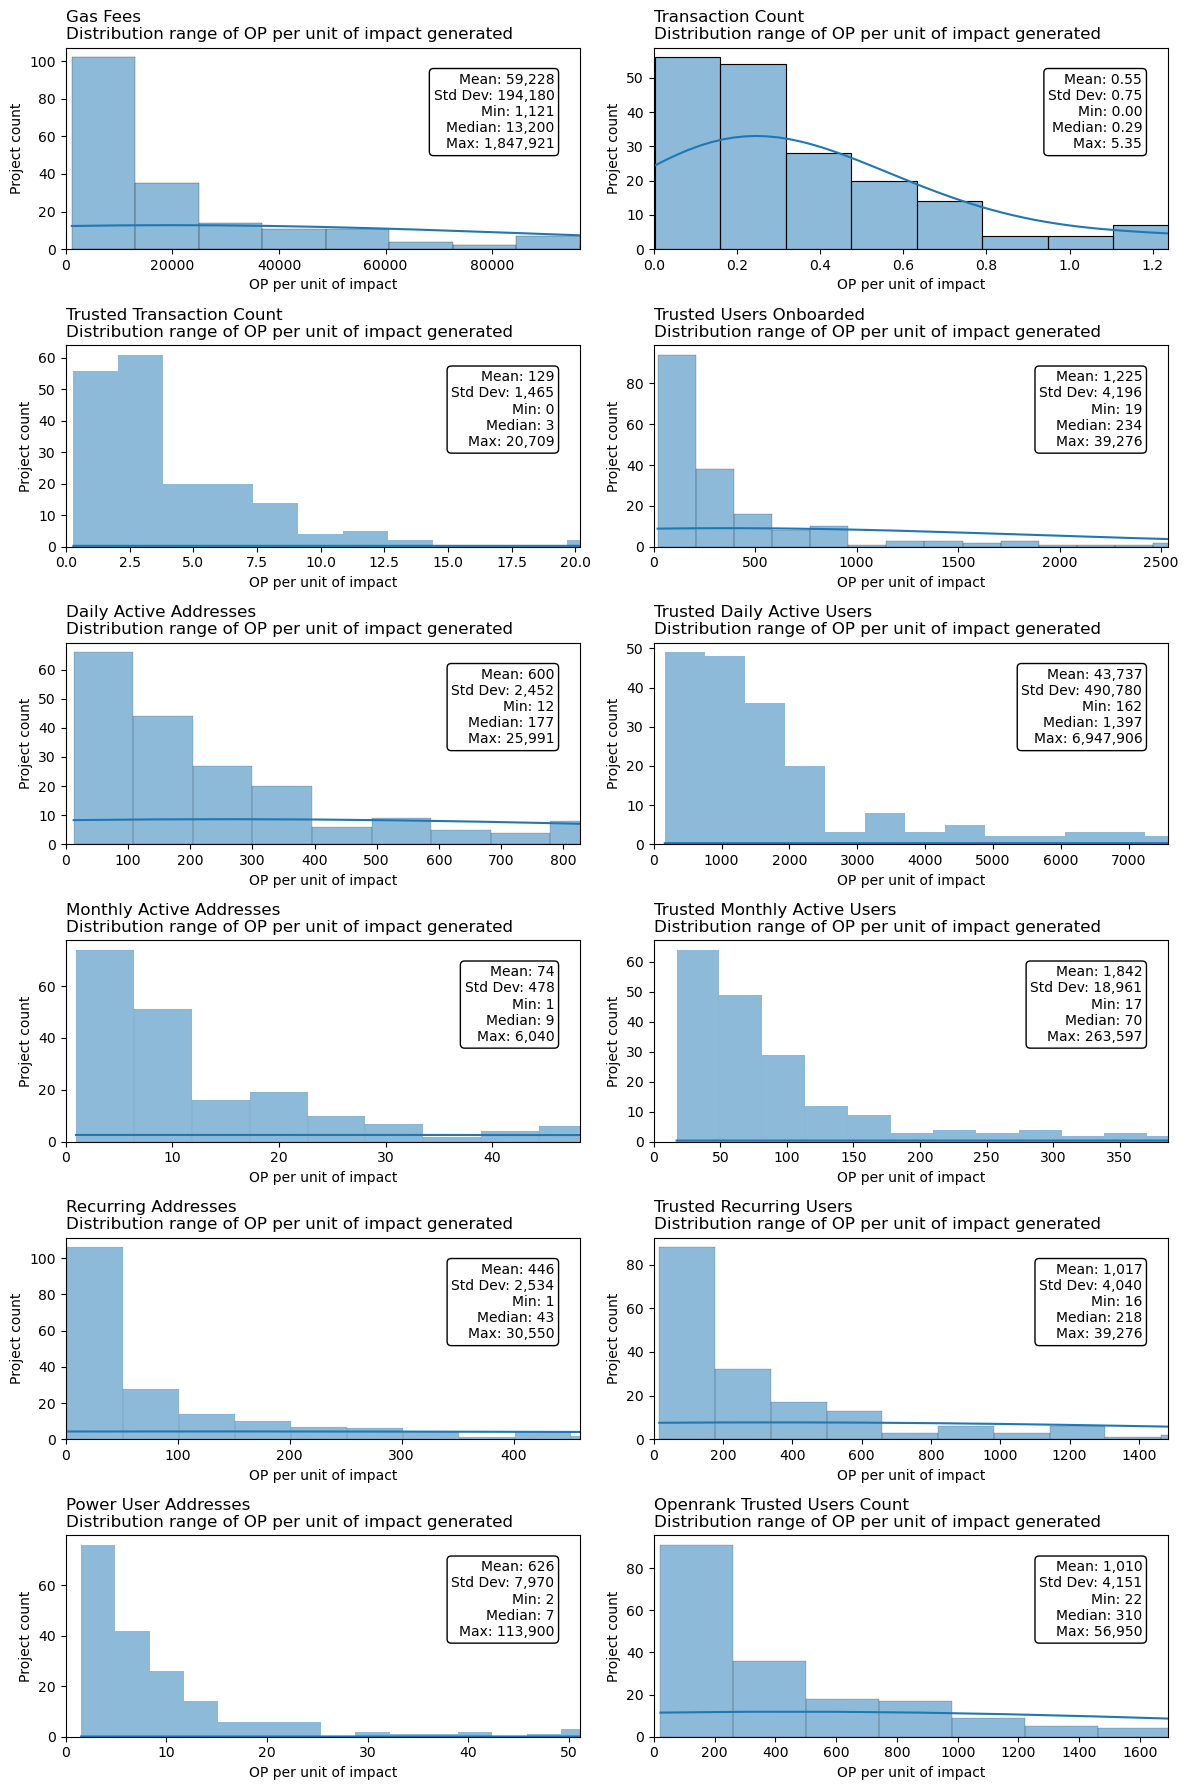

In [8]:
def plot_kde(series, title, ax):

    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    series = series[series > 0]
    
    if series.empty:
        ax.text(0.5, 0.5, "No valid data", ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f"{title} (No Data)", loc='left')
        return

    decimals = 2 if series.mean() < 1 else 0
    pctl_90 = series.quantile(.9)
    stats = {
        "Mean": round(series.mean(), decimals),
        "Std Dev": round(series.std(), decimals),
        "Min": series.min(),
        "Median": round(series.median(), decimals),
        "Max": series.max(),
    }
    
    sns.histplot(data=series, kde=True, stat="count", fill=True, ax=ax)
    
    title = title.replace("_"," ").title()
    ax.set_title(f"{title}\nDistribution range of OP per unit of impact generated", loc='left')
    ax.set_xlim(0,pctl_90)
    ax.set_xlabel("OP per unit of impact")
    ax.set_ylabel("Project count")
    
    stats_text = "\n".join([f"{k}: {v:,.{decimals}f}" if isinstance(v, float) else f"{k}: {v:,.0f}" for k, v in stats.items()])
    ax.text(0.95, 0.5, stats_text, transform=ax.transAxes, ha="right", fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

num_metrics = len(metric_cols)
num_rows = (num_metrics + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 3))
axes = axes.flatten()

for i, metric in enumerate(metric_cols):
    plot_kde(df_projects['rf4_allocation'] / df_projects[metric], metric, axes[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()